In [1]:
import os
import numpy as np
import pywt
import random
import seaborn as sns
import tensorflow as tf
from keras.layers import Add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
  Input, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, 
  Dense, Dropout, GRU, Concatenate, LayerNormalization, MultiHeadAttention, 
  Reshape, Multiply, Softmax
)
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from utils import (
  encode_labels, check_gpu_availability, plot_loss_accuracytupian, 
  evaluate_model, plot_confusion_matrixtupian, plot_tsne, 
  plot_precision_recall_curve_multiclasstupian, plot_roc_curve_multiclasstupian, 
  AdjustLearningRateCallback, denoise2,count_labels,denoise2_iterative2,AdjustLearningRateCallback
)
from utils import plot_precision_recall_curve_multiclass,plot_roc_curve_multiclass2,calculate_g_mean,plot_confusion_matrix,plot_confusion_matrix2,plot_loss_accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1DTranspose


c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.20.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
check_gpu_availability()

GPU 可用


In [3]:
# 加载数据
datafilename1 = "C:\\Users\\Administrator\\Desktop\\MFEG\\dataprocessing\\cinc2017Seg.npz"
data1 = np.load(datafilename1, allow_pickle=True)
X_train, y_train, X_val, y_val, X_test, y_test = data1['ecgstrain'], data1['labelstrain'], data1['ecgsval'], data1['labelsval'], data1['ecgstest'], data1['labelstest']



In [4]:
def denoise_universal_threshold(data):
    coeffs = pywt.wavedec(data=data, wavelet='db7', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db7')
    return rdata

In [5]:
X_train=denoise_universal_threshold(X_train)
X_val=denoise_universal_threshold(X_val)
X_test=denoise_universal_threshold(X_test)

c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [6]:
y_train = encode_labels(y_train)
y_test = encode_labels(y_test)
y_val= encode_labels(y_val)
y_train = to_categorical(y_train, num_classes=4)
y_val=to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [7]:
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Concatenate

def ince_block(inputs, filters, strides=1):
    x1 = Conv1D(filters, 3, strides=strides, padding='same')(inputs)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv1D(filters, 5, strides=1, padding='same')(inputs)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)

    x3 = Conv1D(filters, 9, strides=1, padding='same')(inputs)
    x3 = BatchNormalization()(x3)
    x3 = Activation('relu')(x3)

    x4 = Conv1D(filters, 17, strides=1, padding='same')(inputs)
    x4 = BatchNormalization()(x4)
    x4 = Activation('relu')(x4)

    x = Concatenate()([x1, x2, x3, x4])
    x = Activation('relu')(x)
    return x


In [8]:
from tensorflow.keras.layers import GlobalAveragePooling1D, Reshape, Dense, Multiply
def se_block(input_tensor, reduction_ratio=16):
  channels = input_tensor.shape[-1]
  x = GlobalAveragePooling1D()(input_tensor)
  x = Reshape((1, channels))(x)
  x = Dense(channels // reduction_ratio, activation='relu', use_bias=False)(x)
  x = Dense(channels, activation='sigmoid', use_bias=False)(x)
  x = Multiply()([input_tensor, x])
  return x


In [9]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Dropout, Dense, GRU
from tensorflow.keras.models import Model
import tensorflow as tf

def residual_shrinkage_block_1d(incoming, nb_blocks, out_channels, downsample=False, downsample_strides=2, activation='relu', kernel_size=31,batch_norm=True, bias=True, weights_init='variance_scaling', bias_init='zeros', regularizer='l2', weight_decay=0.0001, trainable=True, name="ResidualShrinkageBlock"):
  residual = incoming
  in_channels = incoming.shape[-1]
  for i in range(nb_blocks):
    identity = residual
    if downsample:
      downsample_strides = 2
    else:
      downsample_strides = 1
    
    if batch_norm:
      residual = BatchNormalization()(residual)
    residual = Activation(activation)(residual)
    residual = Conv1D(out_channels, kernel_size=kernel_size, strides=downsample_strides, padding='same', kernel_initializer=weights_init, use_bias=bias, kernel_regularizer=regularizer, bias_regularizer=regularizer)(residual)
    
    if batch_norm:
      residual = BatchNormalization()(residual)
    residual = Activation(activation)(residual)
    residual = Conv1D(out_channels, kernel_size=kernel_size, strides=1, padding='same', kernel_initializer=weights_init, use_bias=bias, kernel_regularizer=regularizer, bias_regularizer=regularizer)(residual)
    
    # Thresholding
    abs_mean = tf.reduce_mean(tf.abs(residual), axis=1, keepdims=True)
    scales = Dense(out_channels // 4, activation='linear', kernel_regularizer=regularizer, kernel_initializer=weights_init)(abs_mean)
    scales = BatchNormalization()(scales)
    scales = Activation('relu')(scales)
    scales = Dense(out_channels, activation='linear', kernel_regularizer=regularizer, kernel_initializer=weights_init)(scales)
    scales = tf.sigmoid(scales)
    thres = abs_mean * scales
    residual = tf.sign(residual) * tf.maximum(tf.abs(residual) - thres, 0)
    
    # Downsampling and projection
    if downsample_strides > 1:
      identity = Conv1D(out_channels, 1, strides=downsample_strides, padding='same', kernel_initializer=weights_init, use_bias=bias, kernel_regularizer=regularizer, bias_regularizer=regularizer)(identity)
    
    if in_channels != out_channels or downsample:
      identity = Conv1D(out_channels, 1, strides=1, padding='same', kernel_initializer=weights_init, use_bias=bias, kernel_regularizer=regularizer, bias_regularizer=regularizer)(identity)
    
    residual = residual + identity

  return residual


In [10]:
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Add

def res_block31_dilated_causal(inputs, filters, kernel_size=31, dilation_rate=2,strides=1):
  shortcut = inputs
  # 使用扩张卷积和因果卷积
  x = Conv1D(filters, kernel_size, strides=1, padding='causal', dilation_rate=dilation_rate)(inputs)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv1D(filters, kernel_size, strides=1, padding='causal', dilation_rate=dilation_rate)(x)
  x = BatchNormalization()(x)
  
  # 调整shortcut路径以匹配主路径的维度
  if inputs.shape[-1] != filters:
    shortcut = Conv1D(filters, 1, strides=strides, padding='causal')(inputs)  
    shortcut = BatchNormalization()(shortcut)
  
  x = Add()([x, shortcut])
  x = Activation('relu')(x)
  return x


In [11]:
def res_block31(inputs, filters, kernel_size=31, strides=1):
    shortcut = inputs
    
    x = Conv1D(filters, kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    if strides != 1 or inputs.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, strides=strides, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [12]:
def resxnet(num_classes=4):
    input_1 = Input(shape=(4500,1))
    x = Conv1D(64, 12, strides=2, padding='same')(input_1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ince_block(x,64)
    x = residual_shrinkage_block_1d(x, nb_blocks=1, out_channels=32, downsample=True)
    x = res_block31_dilated_causal(x, 32,31,2,1)
    x = se_block(x,32)
    x = residual_shrinkage_block_1d(x, nb_blocks=1, kernel_size=16,out_channels=64, downsample=True)
    x = res_block31_dilated_causal(x, 64,16,2,1)
    x = se_block(x,64)
    x = res_block31(x, 128, kernel_size=9,strides=2)
    x = res_block31(x, 256, kernel_size=6,strides=2)
    x = res_block31(x, 512, kernel_size=3,strides=2)
    x = Dropout(0.2)(x)
    x = GRU(256, return_sequences=False)(x)
    x = Dropout(0.1)(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=input_1, outputs=x)
    return model


In [13]:
model = resxnet()
model.summary()
callback = AdjustLearningRateCallback(factor=0.1, patience=2, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=256, epochs=80, validation_data=(X_val, y_val), callbacks=[callback,early_stopping])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4500, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2250, 64)     832         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2250, 64)     256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 2250, 64)     0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [54]:
y_pred_classes = np.argmax(model.predict(X_test), axis=-1)
y_test_classes = np.argmax(y_test, axis=1)

In [55]:
evaluate_model(model,X_test,y_test)

Precision: 0.7983988534475518
Recall: 0.7593174555350375
F1 Score: 0.7750110179285137
Accuracy: 0.8813354786806115
Class 1 - Precision: 0.8326180257510729, Recall: 0.8546255506607929, F1 Score: 0.8434782608695652
Class 2 - Precision: 0.8911854103343465, Recall: 0.9766822118587608, F1 Score: 0.9319771137952957
Class 3 - Precision: 0.8815566835871405, Recall: 0.7059620596205962, F1 Score: 0.7840481565086532
Class 4 - Precision: 0.5882352941176471, Recall: 0.5, F1 Score: 0.5405405405405405
Class 1 Accuracy: 0.9710378117457763
Class 2 Accuracy: 0.913917940466613
Class 3 Accuracy: 0.8845534995977474
Class 4 Accuracy: 0.9931617055510861


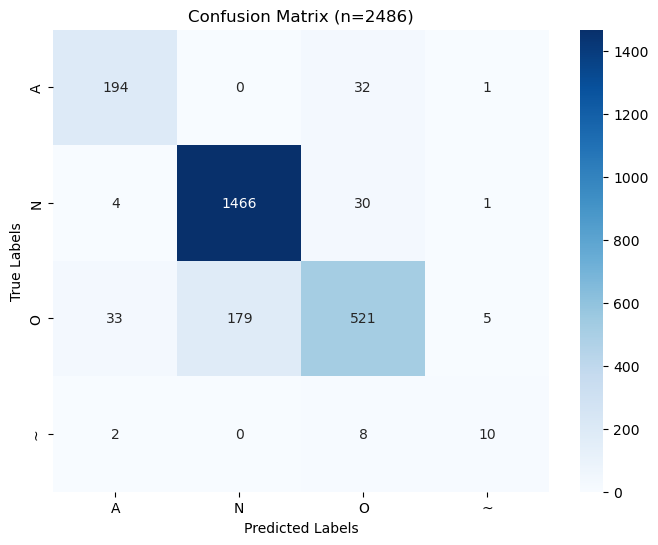

In [56]:
plot_confusion_matrix2(y_test_classes, y_pred_classes, classes=['A', 'N', 'O', '~'])

In [57]:
y1=model.predict(X_test)

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np
import datetime
import os

def plot_precision_recall_curve_multiclasstupian(y_test, y_scores, directory="C:\\Users\\Administrator\\Desktop\\MFEG\\Figure"):
  """
  绘制多类别的查全率-查准率曲线，并保存在指定文件夹。

  参数:
  y_test (array): 真实标签数组。
  y_scores (array): 预测得分数组。
  directory (str): 保存图片的目录。
  """
  num_classes = 4
  y_test_bin = label_binarize(y_test, classes=range(num_classes))
  if y_scores.ndim == 1:
    y_scores = np.reshape(y_scores, (-1, num_classes))

  plt.figure(figsize=(8, 6))
  colors = [(232/255, 56/255, 71/255), (221/255, 108/255, 76/255), 
        (69/255, 123/255, 157/255), (29/255, 53/255, 87/255)]
  linestyles = ['-', '--', '-.', ':']
  labels = ['Precision-Recall curve of AF', 'Precision-Recall curve of normal', 
        'Precision-Recall curve of other', 'Precision-Recall curve of noise']

  # 计算每个类别的查全率-查准率曲线和平均查准率
  precision = dict()
  recall = dict()
  average_precision = dict()
  for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_scores[:, i])
    plt.plot(recall[i], precision[i], color=colors[i], linestyle=linestyles[i], 
         lw=2, label='{} (AP = {:.2f})'.format(labels[i], average_precision[i]))

  # 计算微观平均查全率-查准率曲线和平均查准率
  precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_scores.ravel())
  average_precision["micro"] = average_precision_score(y_test_bin, y_scores, average="micro")
  plt.plot(recall["micro"], precision["micro"], color='deeppink', linestyle=':', 
       linewidth=4, label='Micro-average Precision-Recall curve (AP = {:.2f})'.format(average_precision["micro"]))

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Multi-class Precision-Recall with Micro-average')
  plt.legend(loc='lower left', fontsize=12)
  plt.grid(True)

  # 生成文件名并保存图像
  timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  filename = f'precision_recall_curve_{timestamp}.png'
  if not os.path.exists(directory):
    os.makedirs(directory)
  full_path = os.path.join(directory, filename)
  plt.savefig(full_path, dpi=600)
  plt.close()
  print(f"查全率-查准率曲线图像已保存为: {full_path}")


In [59]:
plot_precision_recall_curve_multiclasstupian(y_test, y1)

查全率-查准率曲线图像已保存为: C:\Users\Administrator\Desktop\MFEG\Figure\precision_recall_curve_20240720-120817.png


In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import datetime
import os

def plot_roc_curve_multiclasstupian(y_test, y_scores, directory="C:\\Users\\Administrator\\Desktop\\MFEG\\Figure"):
  """
  绘制多类别的ROC曲线，并保存在指定文件夹。

  参数:
  y_test (array): 真实标签数组。
  y_scores (array): 预测得分数组。
  directory (str): 保存图片的目录。
  """
  num_classes = 4
  y_test_bin = label_binarize(y_test, classes=range(num_classes))
  if y_scores.ndim == 1:
    y_scores = np.reshape(y_scores, (-1, num_classes))

  plt.figure(figsize=(8, 6))
  colors = [(232/255, 56/255, 71/255), (221/255, 108/255, 76/255), (69/255, 123/255, 157/255), (29/255, 53/255, 87/255)]
  linestyles = ['-', '--', '-.', ':']
  labels = ['ROC curve of AF', 'ROC curve of normal', 'ROC curve of other', 'ROC curve of noise']

  # 计算每个类别的ROC曲线和AUC
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=colors[i], linestyle=linestyles[i], lw=2, label='{} (AUC = {:.2f})'.format(labels[i], roc_auc[i]))

  # 计算微观平均ROC曲线和AUC
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_scores.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4, label='Micro-average ROC curve (AUC = {:.2f})'.format(roc_auc["micro"]))
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multi-class ROC with Micro-average')
  plt.legend(loc='lower right', fontsize=12)
  plt.grid(True)

  # 生成文件名并保存图像
  timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  filename = f'roc_curve_{timestamp}.png'
  if not os.path.exists(directory):
    os.makedirs(directory)
  full_path = os.path.join(directory, filename)
  plt.savefig(full_path, dpi=600)
  plt.close()
  print(f"ROC曲线图像已保存为: {full_path}")

In [61]:
plot_roc_curve_multiclasstupian(y_test, y1)

ROC曲线图像已保存为: C:\Users\Administrator\Desktop\MFEG\Figure\roc_curve_20240720-120818.png


In [62]:
import matplotlib.pyplot as plt
import os
from datetime import datetime 
def plot_loss_accuracytupian(history, save_dir="C:\\Users\\Administrator\\Desktop\\MFEG\\Figure"):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(accuracy, label='Training Accuracy')
  plt.plot(val_accuracy, label='Validation Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()

  # 检查文件夹是否存在，如果不存在，则创建
  if not os.path.exists(save_dir):
    os.makedirs(save_dir)

  # 获取当前日期和时间，用于文件命名
  current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
  file_name = f"loss_accuracy_plot_{current_time}.png"

  # 保存图像到指定的文件夹，并自动命名
  plt.savefig(os.path.join(save_dir, file_name), dpi=600)
  plt.show()


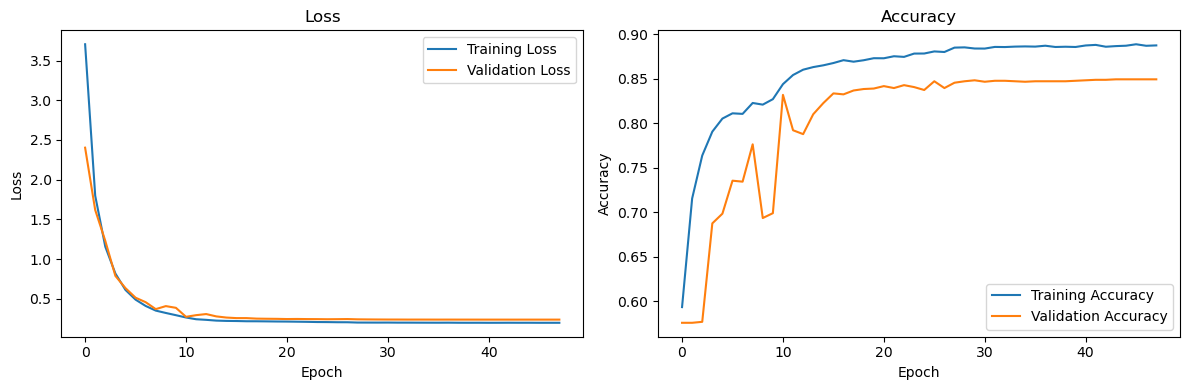

In [63]:
plot_loss_accuracytupian(history)

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import datetime
import os
def plot_confusion_matrixtupian(y_true, y_pred, classes, directory="C:\\Users\\Administrator\\Desktop\\MFEG\\Figure"):
  """
  绘制混淆矩阵，并保存在指定文件夹。

  参数:
  y_true (list): 真实标签。
  y_pred (list): 预测标签。
  classes (list): 类别名称。
  directory (str): 保存图片的目录。
  """
  # 生成文件名
  timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  filename = f'confusion_matrix_{timestamp}.png'

  # 确保目录存在
  if not os.path.exists(directory):
    os.makedirs(directory)

  cm = confusion_matrix(y_true, y_pred)
  num_samples = np.sum(cm)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title(f'Confusion Matrix (n={num_samples})')

  # 保存图片
  full_path = os.path.join(directory, filename)
  plt.savefig(full_path, dpi=600)
  plt.show()
  print(f"图像已保存为: {full_path}")


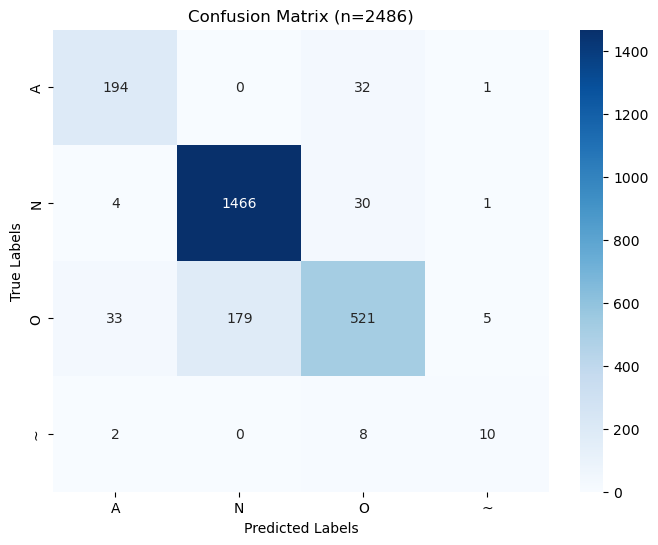

图像已保存为: C:\Users\Administrator\Desktop\MFEG\Figure\confusion_matrix_20240720-120821.png


In [65]:
plot_confusion_matrixtupian(y_test_classes, y_pred_classes, classes=['A', 'N', 'O', '~'])